In [1]:
!nvidia-smi

Thu Sep 14 20:03:13 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.48.07    Driver Version: 515.48.07    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:D8:00.0  On |                  N/A |
|  0%   39C    P8    30W / 370W |    446MiB / 10240MiB |      5%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf 
from tensorflow.keras import callbacks, optimizers, losses
from keras import backend as K
from sklearn.model_selection import train_test_split
import seaborn as sns
import string
import pandas as pd

from hvsrUNet.module.GPRNet import GPRNet
from hvsrUNet.toolbox.smooth import smooth

In [3]:
datasets_4 = np.load('datasets_4.npz')
disp_4 = datasets_4['disp']
hvsr_4 = datasets_4['HVSR']
VVs_4 = datasets_4['VVs']
depth_4 = datasets_4['Depth']

datasets_3 = np.load('datasets_3.npz')
disp_3 = datasets_3['disp']
hvsr_3 = datasets_3['HVSR']
VVs_3 = datasets_3['VVs']
depth_3 = datasets_3['Depth']

disp = np.concatenate((disp_4, disp_3), axis=0)
hvsr = np.concatenate((hvsr_4, hvsr_3), axis=0)
VVs = np.concatenate((VVs_4, VVs_3), axis=0) / 1000.
Depth = np.concatenate((depth_4, depth_3), axis=0) / 100.
Depth = np.expand_dims(Depth, axis=-1)
Y = np.concatenate((VVs, Depth), axis=-1)

X_train, X_test, y_train, y_test = train_test_split(disp, Y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [4]:
yy_train = y_train[..., -1:]
yy_valid = y_valid[..., -1:]
yy_test = y_test[..., -1:]
y_train = y_train[..., :-1]
y_valid = y_valid[..., :-1]
y_test = y_test[..., :-1]

X_train = tf.expand_dims(X_train, axis=2)
y_train = tf.expand_dims(y_train, axis=2)
X_valid = tf.expand_dims(X_valid, axis=2)
y_valid = tf.expand_dims(y_valid, axis=2)
X_test = tf.expand_dims(X_test, axis=2)
y_test = tf.expand_dims(y_test, axis=2)
yy_train = tf.expand_dims(yy_train, axis=2)
yy_valid = tf.expand_dims(yy_valid, axis=2)
yy_test = tf.expand_dims(yy_test, axis=2)

X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_valid.shape, y_valid.shape, yy_train.shape, yy_valid.shape, yy_test.shape

(TensorShape([4777, 512, 1]),
 TensorShape([4777, 512, 1]),
 TensorShape([1494, 512, 1]),
 TensorShape([1494, 512, 1]),
 TensorShape([1195, 512, 1]),
 TensorShape([1195, 512, 1]),
 TensorShape([4777, 1, 1]),
 TensorShape([1195, 1, 1]),
 TensorShape([1494, 1, 1]))

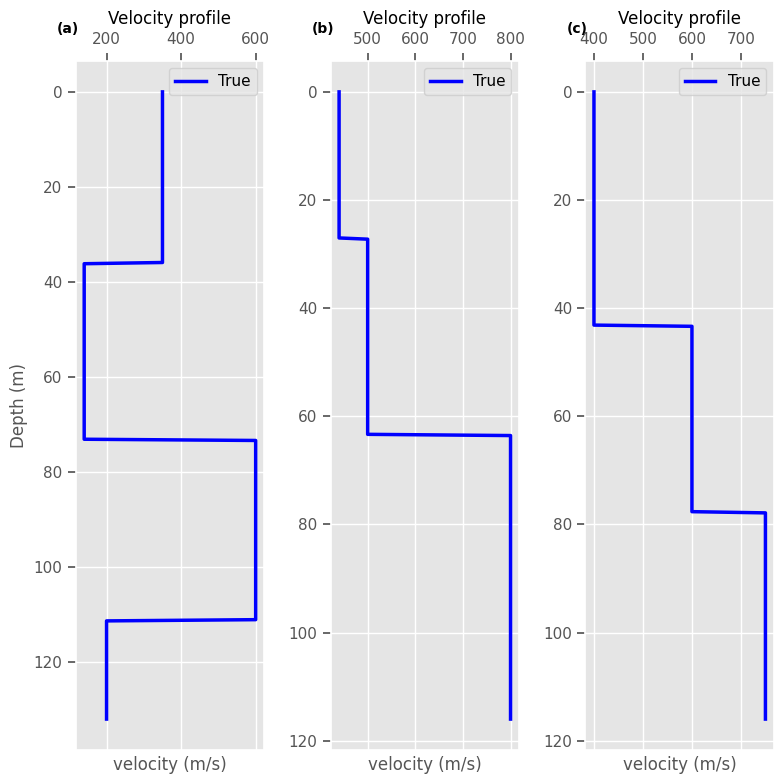

In [5]:
np.random.seed(33)
with plt.style.context('ggplot'):
    sns.set_theme(style=None)
    fig, axes = plt.subplots(1, 3, figsize=(8, 8))
    
    for j, ax in enumerate(axes.flat):
        i = np.random.randint(0, 100)
        #depth_end_predict = np.squeeze(ydepth[i, ...]) * 100
        depth_end_true = np.squeeze(yy_train[i, ...]) * 100
        x2 = np.linspace(0, depth_end_true, len(y_test[i, ...]))

        ax.plot(y_test[i, ...]*1000, x2, color='blue', label='True', linewidth=2.5)
        ax.set_title('Velocity profile')
        ax.set_xlabel('velocity (m/s)')
        ax.legend()
        ax.text(-0.1, 1.04, '('+string.ascii_lowercase[j]+')', transform=ax.transAxes, size=10, weight='bold')
        ax.xaxis.tick_top()
        ax.invert_yaxis()
    axes[0].set_ylabel('Depth (m)')
    fig.tight_layout()
    plt.show()

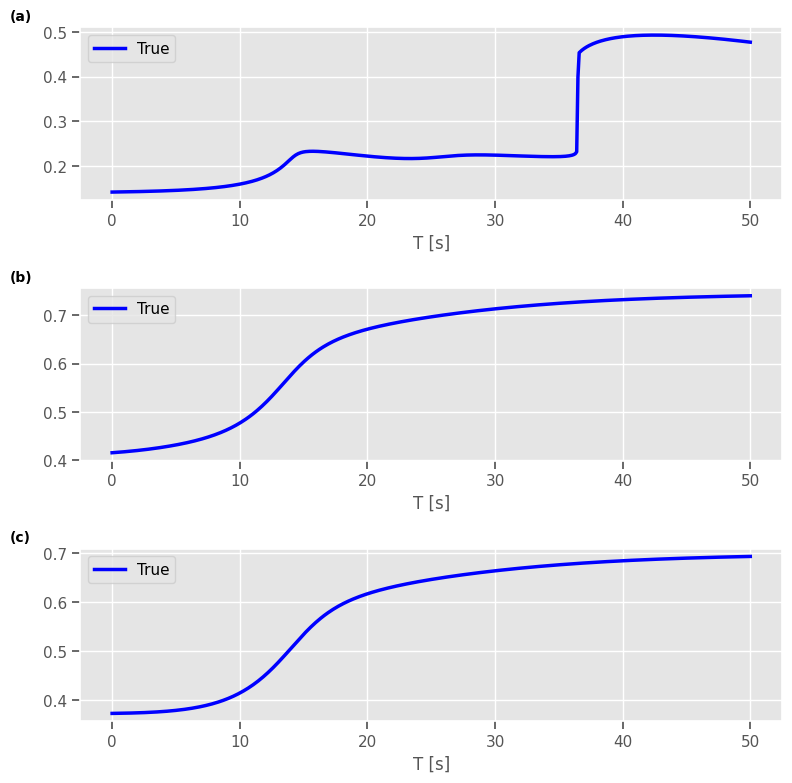

In [5]:
np.random.seed(33)
with plt.style.context('ggplot'):
    sns.set_theme(style=None)
    fig, axes = plt.subplots(3, 1, figsize=(8, 8))
    
    for j, ax in enumerate(axes.flat):
        i = np.random.randint(0, 100)

        x2 = np.linspace(0, 50, len(y_test[i, ...]))

        ax.plot(x2, X_test[i, ...], color='blue', label='True', linewidth=2.5)

        ax.set_xlabel('T [s]')
        ax.legend()
        ax.text(-0.1, 1.04, '('+string.ascii_lowercase[j]+')', transform=ax.transAxes, size=10, weight='bold')

    fig.tight_layout()
    plt.show()

In [6]:
model = GPRNet(im_width=1, im_height=512, neurons=8, kern_sz=10,enable_dropout=False)
# model.summary()
model.load_weights('checkpoints/all_34/Weights/00540.keras')
# model_depth.load_weights('checkpoints/all_34/Weights/disp_depth_00540.keras')

In [7]:
name_checkpoint = 'checkpoints/all_34/Weights/{epoch:04d}.keras' # 保存模型的路径。
log_dir = 'checkpoints/all_34/Logs' # 日志文件保存的目录。
name_csv = 'checkpoints/all_34/Logs/disp.csv' # 将被写入的文件的路径，例如：csv_logger(filename='training.log')。
lr_val = 0.0001
batch_size = 32
epochs = 1000
n_batches = len(X_train) / batch_size
n_batches = int(np.ceil(n_batches))

def R2_score(v_true, v_pred):
    ssres = K.sum(K.square(v_true - v_pred))
    sstot = K.sum(K.square(v_true - K.mean(v_true)))
    return 1 - ssres / sstot

model_checkpoint = callbacks.ModelCheckpoint(name_checkpoint, # 保存模型的路径。
                                #monitor='val_loss',         # 监控的数据。
                                monitor='val_R2_score',
                                verbose=0,                  # 日志显示模式，0或1。
                                save_best_only=False,       # True，那么最近验证误差最低的模型就不会被覆盖。
                                save_weights_only=False,    # True，那么只有模型的权重会被保存。
                                #mode='auto',                # {auto, min, max}的其中之一。
                                mode='max',
                                save_freq=10*n_batches)               # 'epoch'或整数。保存频率。

early_stopping = callbacks.EarlyStopping(monitor='val_loss', # 监控的数据。
                                min_delta=0,                    # 增大或减小的阈值，只有大于这个部分才算作improvement。
                                patience=100,                     # 没有进步的训练轮数，在这之后训练就会被停止。
                                verbose=0,                      # 日志显示模式，0或1。
                                mode='auto',                    # {auto, min, max}的其中之一。
                                baseline=None,                  # 要监控的数量的基准值，如果模型没有显示出基准的改善，则训练将停止。
                                restore_best_weights=False)     # 是否从具有监视器数量的最佳值的时期恢复模型权重。如果为False，则使用在训练的最后一步获得的模型权重。

reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', # 监控的数据。
                                factor=0.5,                     # 触发时将学习率乘以系数的因数。
                                patience=15,                    # 没有进步的训练轮数，在这之后训练速率会被降低。
                                verbose=0,                      # 整数。0：安静，1：更新信息。
                                mode='auto',                    # {auto, min, max}的其中之一。
                                min_delta=0.000001,               # 对于测量新阈值的阈值，只关注巨大的变化。
                                cooldown=0,                     # 在lr被降低之后，训练将在cooldown内的epoch之后继续。
                                min_lr=0)                       # 学习率的下边界。

csv_logger = callbacks.CSVLogger(name_csv, # 将被写入的文件的路径，例如：csv_logger(filename='training.log')。
                                separator=',',              # 用于隔开值的字符串。
                                append=False)               # 如果为True，则将数据添加到现有文件中，而不会重新启动。

optimizer = optimizers.Adam(learning_rate=lr_val)
loss = losses.MeanSquaredError()
model.compile(optimizer=optimizer, loss=loss, metrics=['mae', 'mse', R2_score])

history = model.fit(X_train, y_train,
          validation_data=[X_valid,y_valid],
                  epochs=epochs,
                   batch_size=batch_size,
                   callbacks=[model_checkpoint, early_stopping, reduce_lr, csv_logger],
                   verbose=1)

Epoch 1/1000
150/150 [==============================] - 10s 32ms/step - loss: 0.0393 - mae: 0.1342 - mse: 0.0393 - R2_score: 0.4570 - val_loss: 0.0109 - val_mae: 0.0790 - val_mse: 0.0109 - val_R2_score: 0.8487 - lr: 1.0000e-04
Epoch 2/1000
150/150 [==============================] - 4s 27ms/step - loss: 0.0093 - mae: 0.0686 - mse: 0.0093 - R2_score: 0.8720 - val_loss: 0.0080 - val_mae: 0.0623 - val_mse: 0.0080 - val_R2_score: 0.8894 - lr: 1.0000e-04
Epoch 3/1000
150/150 [==============================] - 4s 26ms/step - loss: 0.0078 - mae: 0.0599 - mse: 0.0078 - R2_score: 0.8926 - val_loss: 0.0074 - val_mae: 0.0587 - val_mse: 0.0074 - val_R2_score: 0.8982 - lr: 1.0000e-04
Epoch 4/1000
150/150 [==============================] - 4s 27ms/step - loss: 0.0069 - mae: 0.0543 - mse: 0.0069 - R2_score: 0.9052 - val_loss: 0.0066 - val_mae: 0.0523 - val_mse: 0.0066 - val_R2_score: 0.9094 - lr: 1.0000e-04
Epoch 5/1000
150/150 [==============================] - 4s 29ms/step - loss: 0.0065 - mae: 0.05

In [36]:
from tensorflow.keras import layers

checkpoint_disp_depth = 'checkpoints/all_34/Weights/disp_depth_{epoch:04d}.keras' # 保存模型的路径。
log_dir = 'checkpoints/all_34/Logs' # 日志文件保存的目录。
name_csv = 'checkpoints/all_34/Logs/disp.csv' # 将被写入的文件的路径，例如：csv_logger(filename='training.log')。
lr_val = 0.0001
batch_size = 32
epochs = 500
n_batches = len(X_train) / batch_size
n_batches = int(np.ceil(n_batches))

model_depth = tf.keras.Sequential([
    layers.Flatten(input_shape=(512, 1)),
    layers.Dropout(0.2),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='relu')
])

model_depth.compile(optimizer='adam',
                loss='mse',
                metrics=['mae', 'mse', 'acc'])

model_checkpoint = callbacks.ModelCheckpoint(checkpoint_disp_depth, # 保存模型的路径。
                                monitor='val_loss',         # 监控的数据。
                                #monitor='val_R2_score',
                                verbose=0,                  # 日志显示模式，0或1。
                                save_best_only=False,       # True，那么最近验证误差最低的模型就不会被覆盖。
                                save_weights_only=False,    # True，那么只有模型的权重会被保存。
                                mode='auto',                # {auto, min, max}的其中之一。
                                #mode='max',
                                save_freq=5*n_batches)               # 'epoch'或整数。保存频率。

history_depth = model_depth.fit(X_train, yy_train,
            validation_data=[X_valid,yy_valid],
            epochs=epochs,
            batch_size=batch_size,
            callbacks=[model_checkpoint])


Epoch 1/500
150/150 [==============================] - 1s 5ms/step - loss: 0.3897 - mae: 0.5144 - mse: 0.3897 - acc: 0.0000e+00 - val_loss: 0.0881 - val_mae: 0.2423 - val_mse: 0.0881 - val_acc: 0.0000e+00
Epoch 2/500
150/150 [==============================] - 1s 4ms/step - loss: 0.1080 - mae: 0.2625 - mse: 0.1080 - acc: 0.0000e+00 - val_loss: 0.0544 - val_mae: 0.1915 - val_mse: 0.0544 - val_acc: 0.0000e+00
Epoch 3/500
150/150 [==============================] - 1s 4ms/step - loss: 0.0709 - mae: 0.2128 - mse: 0.0709 - acc: 0.0000e+00 - val_loss: 0.0345 - val_mae: 0.1499 - val_mse: 0.0345 - val_acc: 0.0000e+00
Epoch 4/500
150/150 [==============================] - 1s 4ms/step - loss: 0.0632 - mae: 0.2006 - mse: 0.0632 - acc: 0.0000e+00 - val_loss: 0.0410 - val_mae: 0.1639 - val_mse: 0.0410 - val_acc: 0.0000e+00
Epoch 5/500
150/150 [==============================] - 1s 4ms/step - loss: 0.0579 - mae: 0.1922 - mse: 0.0579 - acc: 0.0000e+00 - val_loss: 0.0316 - val_mae: 0.1427 - val_mse: 0.03

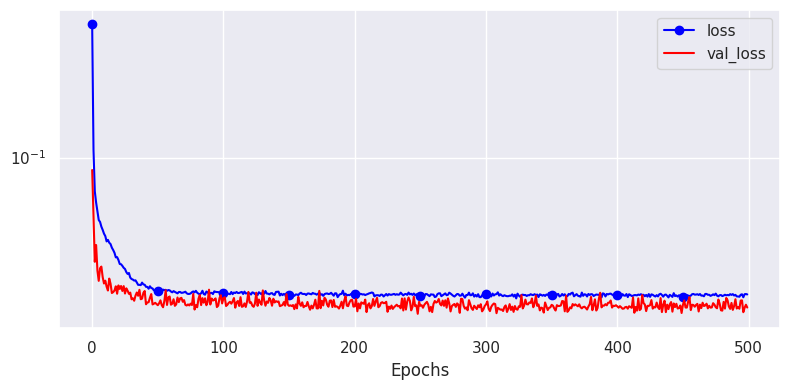

In [40]:
with plt.style.context('ggplot'):
    sns.set_theme(style='darkgrid')
    fig, ax = plt.subplots(1, 1, figsize=(8, 4))
    ax.plot(history_depth.history['loss'], label='loss', marker='o', color='blue', markevery=50)
    ax.plot(history_depth.history['val_loss'], label='val_loss', color='red')
    ax.set_yscale('log')
    ax.set_xlabel('Epochs')
    ax.legend()


plt.tight_layout()
plt.show()

In [26]:
i = np.random.randint(0, 100)

yyyy = model_depth(X_test[i:i+1, ...])
print(yyyy.numpy()*100, yy_test[i, ...].numpy()*100)

[[140.612]] [[135.]]


In [15]:
X_test.shape, y_test.shape, yy_test.shape

(TensorShape([1494, 512, 1]),
 TensorShape([1494, 512, 1]),
 TensorShape([1494, 1, 1]))

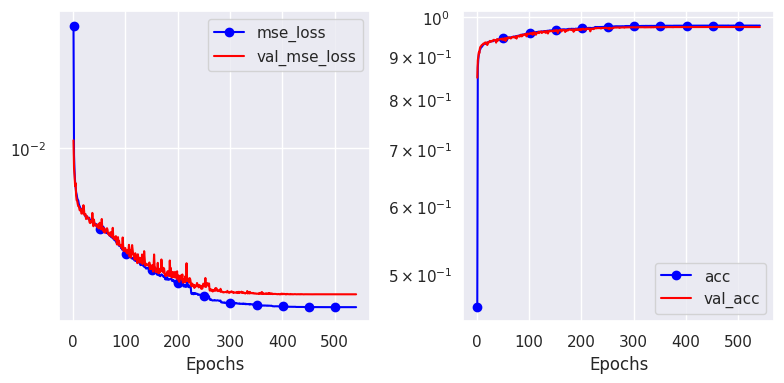

In [49]:
training_log = pd.read_csv('checkpoints/all_34/Logs/disp.csv')
training_log.head()

mse_loss = training_log['loss']
val_mse_loss = training_log['val_loss']
acc = training_log['R2_score']
val_acc = training_log['val_R2_score']

accu = {'mse_loss': mse_loss, 
        'val_mse_loss': val_mse_loss,
        'acc': acc,
        'val_acc': val_acc}

value = [mse_loss, val_mse_loss, acc, val_acc]
name = ['mse_loss', 'val_mse_loss', 'acc', 'val_acc']

epochs = range(1, len(acc) + 1)

with plt.style.context('ggplot'):
    sns.set_theme(style='darkgrid')
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))

    for i, ax in enumerate(axes):

        ax.plot(epochs, value[2*i], label=name[2*i], marker='o', color='blue', markevery=50)
        ax.plot(epochs, value[2*i+1], label=name[2*i+1], color='red')
        ax.set_yscale('log')
        ax.set_xlabel('Epochs')
        ax.legend()
        #ax.set_title(name)
    
    plt.tight_layout()

plt.show()
    

In [10]:
ypred = model.predict(X_test[:100, ...])
ydepth = model_depth.predict(X_test[:100, ...])
#ypred = model.predict(X_train)

133.25016498565674
132.30351209640503
138.00736665725708


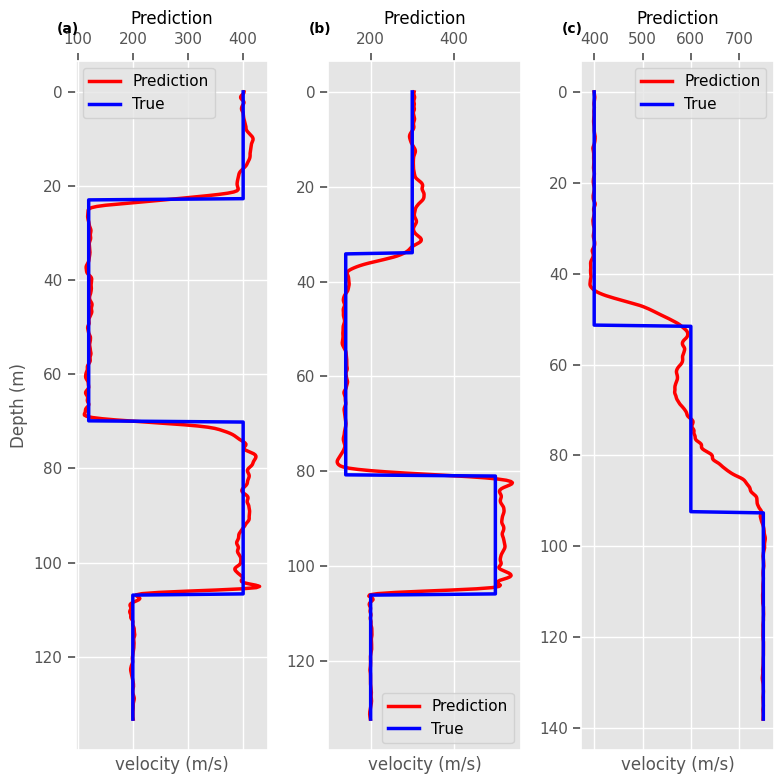

In [11]:
with plt.style.context('ggplot'):
    sns.set_theme(style=None)
    fig, axes = plt.subplots(1, 3, figsize=(8, 8))
    
    for j, ax in enumerate(axes.flat):
        i = np.random.randint(0, 100)
        depth_end = np.squeeze(ydepth[i, ...]) * 100
        depth_end_true = np.squeeze(yy_test[i, ...]) * 100
        print(depth_end)
        yy = smooth(np.squeeze(ypred[i, ...]), window_len=10, window='blackman')
        x1 = np.linspace(0, depth_end, len(yy))
        x2 = np.linspace(0, depth_end_true, len(y_test[i, ...]))

        ax.plot(yy*1000, x1, color='red', label='Prediction', linewidth=2.5)
        ax.plot(y_test[i, ...]*1000, x2, color='blue', label='True', linewidth=2.5)
        ax.set_title('Prediction')
        ax.set_xlabel('velocity (m/s)')
        ax.legend()
        ax.text(-0.1, 1.04, '('+string.ascii_lowercase[j]+')', transform=ax.transAxes, size=10, weight='bold')
        ax.xaxis.tick_top()
        ax.invert_yaxis()
    axes[0].set_ylabel('Depth (m)')
    fig.tight_layout()
    plt.show()